# Optimize denovo reference
    This script uses scripts provided by dDocent to de novo assembly in CD-HIT
    https://www.ddocent.com/assembly/
    
    Run dDocent first with basic commands. Use individuals retained from filtering to make assembly

In [1]:
!source activate py36

/usr/bin/sh: line 0: source: activate: file not found


In [63]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [4]:
root = "/data/gpfs/home/tfaske/g/balsam"

In [5]:
cd $root

/data/gpfs/assoc/parchmanlab/tfaske/balsam


In [6]:
pwd

'/data/gpfs/assoc/parchmanlab/tfaske/balsam'

# Sample random fastq for optimizer
 

In [9]:
%load_ext rpy2.ipython

In [20]:
%%R
library(plyr)

Pop_ID = read.csv('ddocent/Pop_ID.csv')
print(paste0('range of individuals per Pop: ',range(count(Pop_ID,vars='Pop')$freq)[1],'-',range(count(Pop_ID,vars='Pop')$freq)[2]))
print(paste0('Number of populations: ',length(unique(Pop_ID$Pop))))

[1] "range of individuals per Pop: 8-14"
[1] "Number of populations: 32"


In [22]:
%%R 
pop_unique <- unique(Pop_ID$Pop)

fq_list <- vector('character') 
for (i in 1:length(pop_unique)){
  fq <- as.character(Pop_ID$All[which(Pop_ID$Pop == pop_unique[i])])
  fq_rand <- sample(fq,2)
  fq_list <- c(fq_list,fq_rand)
}
print(length(fq_list))
print(fq_list[1])

[1] 64
[1] "BS_AN_5"


In [ ]:
# %%R
### cp fastqs and move to refOpt dir ###
fq_files <- paste0('cp /data/gpfs/home/tfaske/g/balsam/fastq/',fq_list,'.F.fq.gz')
fq_files <- paste0(fq_files," /data/gpfs/home/tfaske/g/balsam/refOpt")
print(fq_files[2])

cp_fq_files <- c('#!/usr/bin/',fq_files)

write.table(cp_fq_files,"refOpt/cp_ref.sh",
            sep = "\n",quote = F,row.names = F,col.names = F)

# run cp_ref.sh
    cd /data/gpfs/home/tfaske/g/balsam/refOpt
    bash cp_ref.sh

# make a slurm script to run ReferenceOpt.sh 
    ReferenceOpt.sh minK1 maxK1 minK2 maxK2 Assembly_Type Processors

In [26]:
refOpt = '/data/gpfs/home/tfaske/g/src/refOpt/./ReferenceOpt.sh'
refOpt_dir = '/data/gpfs/home/tfaske/g/balsam/refOpt'

In [28]:
cd $refOpt_dir

/data/gpfs/assoc/parchmanlab/tfaske/balsam/refOpt


In [282]:
### select options
minK1 = 4
maxK1 = 10
minK2 = 4
maxK2 = 10
Type = 'SE' 
Cpus = 16
email = 'tfaske@nevada.unr.edu'

In [36]:
def write_refOpt_sh(refOpt,minK1,maxK1,minK2,maxK2,Type,Cpus,email):
    with open("run_refOpt.sh", "w") as o:
        o.write("""#!/usr/bin/env bash
#SBATCH --account=cpu-s1-bionres-0
#SBATCH --partition=cpu-s1-bionres-0
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --job-name refOpt
#SBATCH --output output_refOpt.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (Cpus,email))

        #ReferenceOpt.sh minK1 maxK1 minK2 maxK2 Assembly_Type Processors
        o.write("""%s %d %d %d %d %s %d"""% (refOpt,minK1,maxK1,minK2,maxK2,Type,Cpus))

In [37]:
write_refOpt_sh(refOpt,minK1,maxK1,minK2,maxK2,Type,Cpus,email)

# run refOpt.sh in slurm
    cd /data/gpfs/home/tfaske/g/balsam/refOpt
    source activate ddocent_env
    sbatch run_refOpt.sh

# Visualize kopt

In [107]:
cd $refOpt_dir

/data/gpfs/assoc/parchmanlab/tfaske/balsam/refOpt


R[write to console]: Parsed with column specification:
cols(
  k1 = col_double(),
  k2 = col_double(),
  c = col_double(),
  contig = col_double()
)



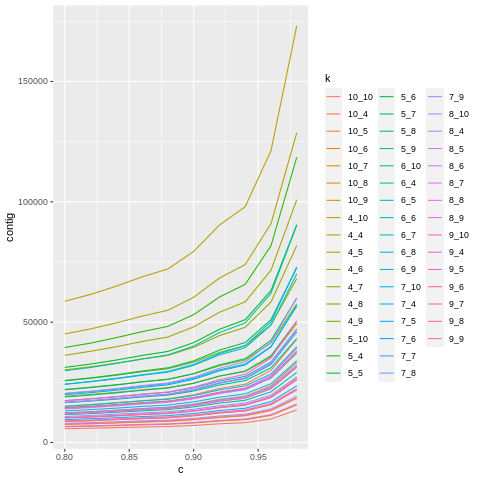

In [109]:
%%R
library(readr)
library(ggplot2)

kopt <- read_table2('kopt.data',col_names = c('k1','k2','c','contig'))
kopt$k <- paste0(kopt$k1,'_',kopt$k2)

ggplot(data=kopt,aes(x=c,y=contig,colour=k)) + 
  geom_line() 

c = .94 is the winner!

# MapOpt now!!!
    This script assembles references across cutoff values and then maps 20 random samples and evaluates mappings to the reference, along with number of contigs and coverage.
    
    Moves fastq files from refOpt, runs dDocent to get trimmed files
    
    choose mapOpt sim from kopt above: 94 add +-2 (e.g. 92,96)

In [113]:
cd $root

/data/gpfs/assoc/parchmanlab/tfaske/balsam


In [118]:
sim_val = [92,94,96]

In [127]:
src_dir = '/data/gpfs/home/tfaske/g/src/refOpt/./'
mapOpt_sh = []
for sim in sim_val:
    sh = src_dir + "Map%d.sh"%(sim)
    mapOpt_sh.append(sh)

In [129]:
len(mapOpt_sh), mapOpt_sh

(3,
 ['/data/gpfs/home/tfaske/g/src/refOpt/./Map92.sh',
  '/data/gpfs/home/tfaske/g/src/refOpt/./Map94.sh',
  '/data/gpfs/home/tfaske/g/src/refOpt/./Map96.sh'])

In [130]:
#RefMapOpt minK1 maxK1 minK2 maxK2 cluster_similarity Assembly_Type Num_of_Processors
### select options
minK1 = 4
maxK1 = 10
minK2 = 4
maxK2 = 10
Type = 'SE' 
Cpus = 32
email = 'fasket@nevada.unr.edu'

In [143]:
cd $refOpt_dir

/data/gpfs/assoc/parchmanlab/tfaske/balsam/refOpt


In [133]:
def write_mapOpt_sh(mapOpt_sh,sim_val,minK1,maxK1,minK2,maxK2,Type,Cpus,email):
    for i in range(0,len(mapOpt_sh)):
        sh = mapOpt_sh[i]
        sim = sim_val[i]
        with open("run_mapOpt%d.sh" % (sim), "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=cpu-s1-bionres-0
#SBATCH --partition=cpu-s1-bionres-0
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --job-name mapOpt%d
#SBATCH --output output_mapOpt%d.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (Cpus,sim,sim,email))

        #RefMapOpt minK1 maxK1 minK2 maxK2 cluster_similarity Assembly_Type Num_of_Processors
            o.write("""%s %d %d %d %d 0.%d %s %d"""% (sh,minK1,maxK1,minK2,maxK2,sim,Type,Cpus))

In [135]:
write_mapOpt_sh(mapOpt_sh,sim_val,minK1,maxK1,minK2,maxK2,Type,Cpus,email)

In [144]:
mapShells = !find $refOpt_dir -name 'run_map*.sh'
mapShells

['/data/gpfs/home/tfaske/g/balsam/refOpt/run_mapOpt92.sh',
 '/data/gpfs/home/tfaske/g/balsam/refOpt/run_mapOpt96.sh',
 '/data/gpfs/home/tfaske/g/balsam/refOpt/run_mapOpt94.sh']

In [147]:
def write_sbatch_mapOpt(mapShells):
         with open("sbatch_mapOpt.sh", "w") as o:
            o.write("""#!/usr/bin/env bash \n""")
            for sh in mapShells:
                o.write("""sbatch %s\n""" % (sh))

In [148]:
write_sbatch_mapOpt(mapShells)

# Run all mapOpt*sh
    cd /data/gpfs/home/tfaske/g/balsam/refOpt
    source activate ddocent_env
    bash sbatch_mapOpt.sh

# Read in mapping results and make decision

In [155]:
cd $refOpt_dir

/data/gpfs/assoc/parchmanlab/tfaske/balsam/refOpt


In [157]:
mapResults = !ls mapping*.results
mapResults

['mapping92.results', 'mapping94.results', 'mapping96.results']

In [163]:
for mR in mapResults:
    print(mR)
    !cat $mR
    print('\n')

mapping92.results
Cov	Non0Cov	Contigs	MeanContigsMapped	K1	K2	SUM Mapped	SUM Properly	Mean Mapped	Mean Properly	MisMatched
21.2102	25.4514	90322	75223.1	4	4	38315398	0	1.91577e+06	0	0
27.4099	31.6444	68292	59120.6	4	5	37438087	0	1.8719e+06	0	0
33.8977	38.092	54104	48123.2	4	6	36680659	0	1.83403e+06	0	0
40.5842	44.666	44394	40317.1	4	7	36034696	0	1.80173e+06	0	0
47.3697	51.2751	37406	34540.3	4	8	35439150	0	1.77196e+06	0	0
54.8436	58.6044	31882	29824.1	4	9	34971532	0	1.74858e+06	0	0
62.5257	66.1111	27535	26031.2	4	10	34434178	0	1.72171e+06	0	0
30.5653	35.6068	60424	51857.3	5	4	36938199	0	1.84691e+06	0	0
38.405	43.2715	47017	41718.8	5	5	36114555	0	1.80573e+06	0	0
46.2131	50.8908	38375	34838.1	5	6	35469488	0	1.77347e+06	0	0
54.0716	58.5285	32281	29813.7	5	7	34910754	0	1.74554e+06	0	0
62.3067	66.5206	27573	25817.7	5	8	34360924	0	1.71805e+06	0	0
71.1043	75.0722	23854	22585.7	5	9	33923842	0	1.69619e+06	0	0
80.731	84.4308	20709	19795.2	5	10	33438753	0	1.67194e+06	0	0
39.2425	44.8235	45655	3996

In [174]:
%%R 
library(readr)
setwd('/data/gpfs/home/tfaske/g/balsam/refOpt')
map_files <- list.files(pattern='mapping*')
print(map_files)

for (i in 1:length(map_files)){
    name <- map_files[i]
    print(name)
    infile <- read_table2(map_files[i])
    infile$k <- paste0(infile$K1,'_',infile$K2)
    assign(infile,name)
ls()

RParsingError: Parsing status not OK

In [271]:
%%R 
library(data.table)
map_df <- list()
for (m in map_files){
    infile <- read_table2(m)
    infile$k <- paste0(infile$K1,'_',infile$K2)
    infile$sim <- gsub('\\D','',m)
    infile$ratio <- scale(infile$SUM_1) / (scale(infile$MeanContigsMapped) / scale(infile$Cov) )
    map_df <- append(map_df,list(infile))
}
#map_df
map_df <- rbindlist(map_df)
head(map_df)

R[write to console]: Parsed with column specification:
cols(
  Cov = col_double(),
  Non0Cov = col_double(),
  Contigs = col_double(),
  MeanContigsMapped = col_double(),
  K1 = col_double(),
  K2 = col_double(),
  SUM = col_double(),
  Mapped = col_double(),
  SUM_1 = col_double(),
  Properly = col_double(),
  Mean = col_double(),
  Mapped_1 = col_character(),
  Mean_1 = col_character(),
  Properly_1 = col_character(),
  MisMatched = col_character()
)

R[write to console]: Warning:
R[write to console]:  49 parsing failures.
row col   expected     actual                file
  1  -- 15 columns 11 columns 'mapping92.results'
  2  -- 15 columns 11 columns 'mapping92.results'
  3  -- 15 columns 11 columns 'mapping92.results'
  4  -- 15 columns 11 columns 'mapping92.results'
  5  -- 15 columns 11 columns 'mapping92.results'
... ... .......... .......... ...................
See problems(...) for more details.


R[write to console]: Parsed with column specification:
cols(
  Cov = col_double()

       Cov Non0Cov Contigs MeanContigsMapped K1 K2      SUM Mapped   SUM_1
1: 21.2102 25.4514   90322           75223.1  4  4 38315398      0 1915770
2: 27.4099 31.6444   68292           59120.6  4  5 37438087      0 1871900
3: 33.8977 38.0920   54104           48123.2  4  6 36680659      0 1834030
4: 40.5842 44.6660   44394           40317.1  4  7 36034696      0 1801730
5: 47.3697 51.2751   37406           34540.3  4  8 35439150      0 1771960
6: 54.8436 58.6044   31882           29824.1  4  9 34971532      0 1748580
   Properly Mean Mapped_1 Mean_1 Properly_1 MisMatched   k sim     ratio
1:        0    0     <NA>   <NA>       <NA>       <NA> 4_4  92 -1.040642
2:        0    0     <NA>   <NA>       <NA>       <NA> 4_5  92 -1.115966
3:        0    0     <NA>   <NA>       <NA>       <NA> 4_6  92 -1.158292
4:        0    0     <NA>   <NA>       <NA>       <NA> 4_7  92 -1.178119
5:        0    0     <NA>   <NA>       <NA>       <NA> 4_8  92 -1.171218
6:        0    0     <NA>   <NA>     

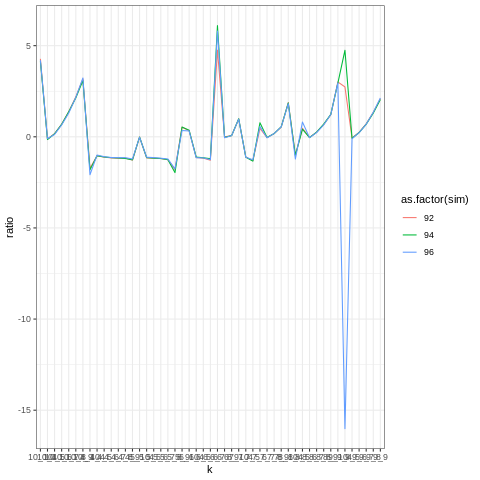

In [273]:
%%R
ggplot(data=map_df,aes(x=k,y=ratio,color=as.factor(sim))) + 
    geom_line(aes(group=as.factor(sim))) + theme_bw()

In [280]:
%%R 
colMeans(map_df[,c(1:7,9)])

              Cov           Non0Cov           Contigs MeanContigsMapped 
     7.485016e+01      7.949669e+01      2.989311e+04      2.694955e+04 
               K1                K2               SUM             SUM_1 
     7.000000e+00      7.000000e+00      3.331760e+07      1.665880e+06 


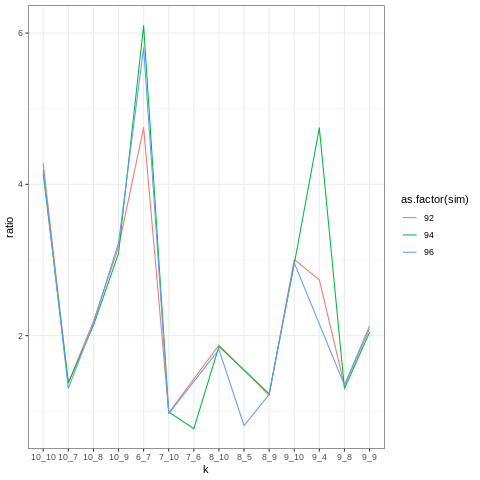

In [272]:
%%R
map_top <- map_df[which(map_df$ratio > quantile(map_df$ratio,probs=.75)),]

#SUM Properly
ggplot(data=map_top,aes(x=k,y=ratio,color=as.factor(sim))) + 
    geom_line(aes(group=as.factor(sim))) + theme_bw()

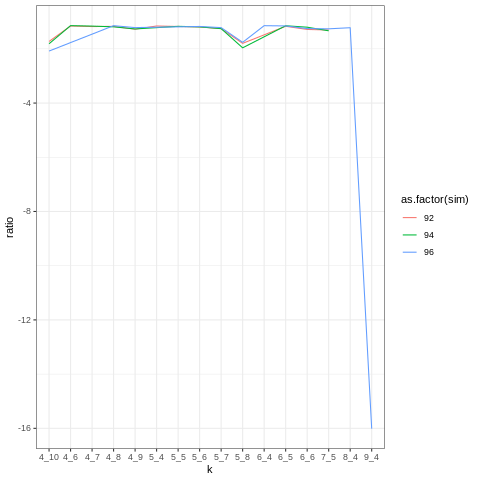

In [274]:
%%R
map_bot <- map_df[which(map_df$ratio < quantile(map_df$ratio,probs=.25)),]

#SUM Properly
ggplot(data=map_bot,aes(x=k,y=ratio,color=as.factor(sim))) + 
    geom_line(aes(group=as.factor(sim))) + theme_bw()

In [281]:
%%R
map_df[which(map_df$k %in% c('6_7','5_8','9_4')),c(1:7,9,17)]

       Cov Non0Cov Contigs MeanContigsMapped K1 K2      SUM   SUM_1 sim
1: 62.3067 66.5206   27573           25817.7  5  8 34360924 1718050  92
2: 66.7939 71.4354   25480           23818.0  6  7 34039530 1701980  92
3: 64.8160 71.0825   26098           23792.7  9  4 33832650 1691630  92
4: 54.6441 58.9098   29673           27510.8  5  8 32430164 1621510  94
5: 58.2484 62.8885   27489           25448.7  6  7 32024975 1601250  94
6: 56.2789 62.5360   28314           25470.6  9  4 31870750 1593540  94
7: 49.2836 53.4538   36041           33219.0  5  8 35525560 1776278  96
8: 52.5834 57.1959   33454           30745.8  6  7 35183583 1759180  96
9: 50.0079 56.3079   35077           31135.1  9  4 35083514 1754180  96


# Map results 
    sim=94 K1=6 k2=7 WINNER
    
    remake reference in fastq using these parameters. Move reference.fasta to assembly dir

# OLD

[1] "92" "94" "96"


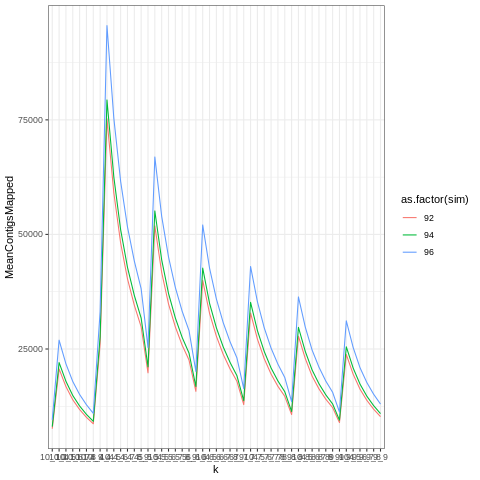

In [213]:
%%R
library(ggplot2)
knitr::opts_chunk$set(fig.width=7, fig.height=5) 

print(unique(map_df$sim))
#MeanContigsMapped
ggplot(data=map_df,aes(x=k,y=MeanContigsMapped,color=as.factor(sim))) + 
    geom_line(aes(group=as.factor(sim))) + theme_bw()

[1] "92" "94" "96"


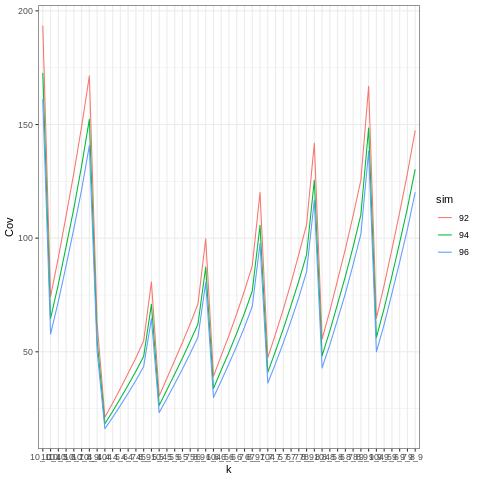

In [203]:
%%R
library(ggplot2)
options(repr.plot.width=10, repr.plot.height=8)

print(unique(map_df$sim))
#coverage
ggplot(data=map_df,aes(x=k,y=Cov,color=sim)) + 
    geom_line(aes(group=sim)) + theme_bw()

[1] "92" "94" "96"


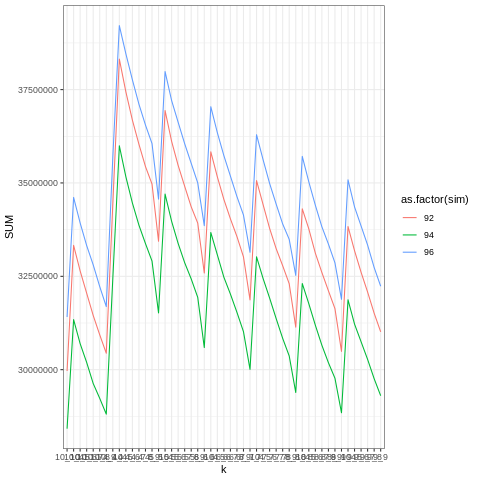

In [233]:
%%R
library(ggplot2)
knitr::opts_chunk$set(fig.width=7, fig.height=5) 

print(unique(map_df$sim))
#SUM
ggplot(data=map_df,aes(x=k,y=SUM,color=as.factor(sim))) + 
    geom_line(aes(group=as.factor(sim))) + theme_bw()

  [1] "10_10" "10_10" "10_10" "10_4"  "10_4"  "10_4"  "10_5"  "10_5"  "10_5" 
 [10] "10_6"  "10_6"  "10_6"  "10_7"  "10_7"  "10_7"  "10_8"  "10_8"  "10_8" 
 [19] "10_9"  "10_9"  "10_9"  "4_10"  "4_10"  "4_10"  "4_4"   "4_4"   "4_4"  
 [28] "4_5"   "4_5"   "4_5"   "4_6"   "4_6"   "4_6"   "4_7"   "4_7"   "4_7"  
 [37] "4_8"   "4_8"   "4_8"   "4_9"   "4_9"   "4_9"   "5_10"  "5_10"  "5_10" 
 [46] "5_4"   "5_4"   "5_4"   "5_5"   "5_5"   "5_5"   "5_6"   "5_6"   "5_6"  
 [55] "5_7"   "5_7"   "5_7"   "5_8"   "5_8"   "5_8"   "5_9"   "5_9"   "5_9"  
 [64] "6_10"  "6_10"  "6_10"  "6_4"   "6_4"   "6_4"   "6_5"   "6_5"   "6_5"  
 [73] "6_6"   "6_6"   "6_6"   "6_7"   "6_7"   "6_7"   "6_8"   "6_8"   "6_8"  
 [82] "6_9"   "6_9"   "6_9"   "7_10"  "7_10"  "7_10"  "7_4"   "7_4"   "7_4"  
 [91] "7_5"   "7_5"   "7_5"   "7_6"   "7_6"   "7_6"   "7_7"   "7_7"   "7_7"  
[100] "7_8"   "7_8"   "7_8"   "7_9"   "7_9"   "7_9"   "8_10"  "8_10"  "8_10" 
[109] "8_4"   "8_4"   "8_4"   "8_5"   "8_5"   "8_5"   "8_6"   "8

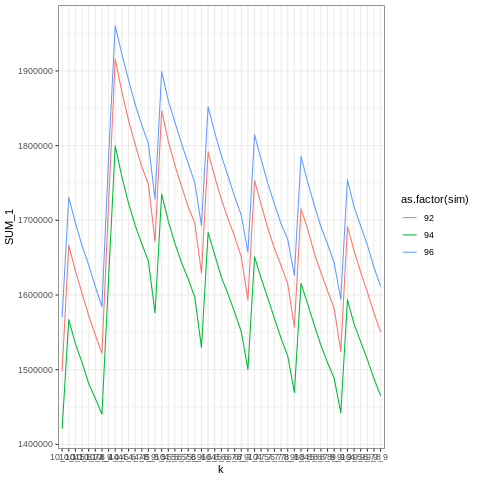

In [231]:
%%R
library(ggplot2)
options(repr.plot.width=10, repr.plot.height=8)

print(sort(map_df$k))
#SUM Properly
ggplot(data=map_df,aes(x=k,y=SUM_1,color=as.factor(sim))) + 
    geom_line(aes(group=as.factor(sim))) + theme_bw()

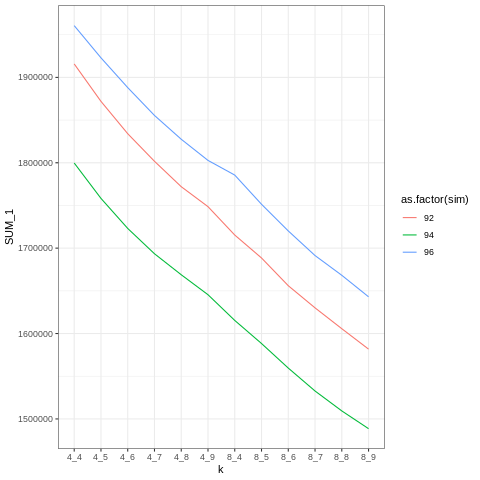

In [236]:
%%R
library(ggplot2)
options(repr.plot.width=10, repr.plot.height=8)

#map96_df <- map_df[which(map_df$sim == '96')]
#print(which(map96_df$k %in% c('8_4','8_5','8_6','8_7','8_8','8_9','8_10')))
sub_df <- map_df[which(map_df$k %in% c('4_4','4_5','4_6','4_7','4_8','4_9',
                                      '8_4','8_5','8_6','8_7','8_8','8_9')),]

#SUM Properly
ggplot(data=sub_df,aes(x=k,y=SUM_1,color=as.factor(sim))) + 
    geom_line(aes(group=as.factor(sim))) + theme_bw()

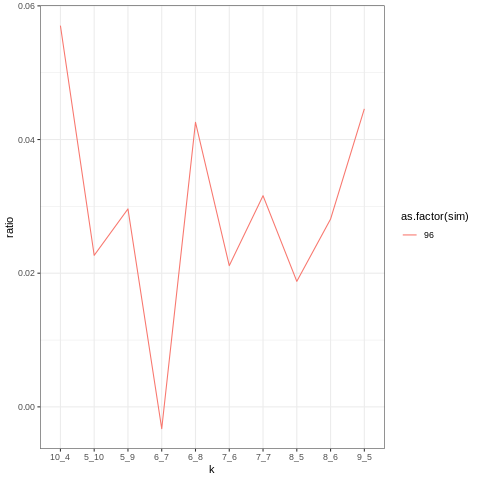

In [255]:
%%R
map96_df <- map_df[which(map_df$sim == '96'),]
#print(map96_df)
#map96_df$ratio <- (map96_df$SUM_1 / map96_df$SUM) + (map96_df$MeanContigsMapped / map96_df$Contigs)


map96_df$ratio <- scale(map96_df$MeanContigsMapped / map96_df$SUM_1) * scale(map96_df$Cov)

map96_sub <- map96_df[which(map96_df$ratio > quantile(map96_df$ratio,probs=.80)),]

#SUM Properly
ggplot(data=map96_sub,aes(x=k,y=ratio,color=as.factor(sim))) + 
    geom_line(aes(group=as.factor(sim))) + theme_bw()

Run all map 

In [ ]:
src_dir = '/data/gpfs/home/tfaske/g/src/refOpt/./'
mapOpt_sh = !find $src_dir -name 'Map*.sh'

In [ ]:
len(mapOpt_sh), mapOpt_sh

In [ ]:
sim_val = []
for sh in mapOpt_sh:
    sim = re.findall(r'\d+', sh)
    sim_val.append(sim)
sim_val = list(chain.from_iterable(sim_val))
sim_val

In [ ]:
def write_mapOpt_sh(mapOpt_sh,sim_val,minK1,maxK1,minK2,maxK2,Type,Cpus,email):
    for i in range(0,len(mapOpt_sh)):
        sh = mapOpt_sh[i]
        sim = sim_val[i]
        with open("run_mapOpt%s.sh" % (sim), "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=cpu-s1-bionres-0
#SBATCH --partition=cpu-s1-bionres-0
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --job-name refOpt%s
#SBATCH --output output_refOpt%s.txt
#SBATCH --mail-type END
#SBATCH --mail-user %s\n\n""" % (Cpus,sim,sim,email))

        #RefMapOpt minK1 maxK1 minK2 maxK2 cluster_similarity Assembly_Type Num_of_Processors
            o.write("""%s %d %d %d %d %s %s %d"""% (sh,minK1,maxK1,minK2,maxK2,sim,Type,Cpus))

In [ ]:
write_mapOpt_sh(mapOpt_sh,sim_val,minK1,maxK1,minK2,maxK2,Type,Cpus,email)

In [ ]:
def write_sbatch_mapOpt(mapShells):
         with open("sbatch_mapOpt.sh" % (sim), "w") as o:
            o.write("""#!/usr/bin/env bash \n""")
            for sh in mapShells:
                o.write("""sbatch %s\n""" % (sh))

In [ ]:
write_sbatch_mapOpt(mapShells)

In [39]:
!mkdir mapOpt

In [41]:
mapOpt_dir = '/data/gpfs/home/tfaske/g/balsam/mapOpt'

In [40]:
fastq_files = []
for seqdir in ['fastq/']:
    os.chdir('{}/{}'.format(root, seqdir))
    files = !find . -name '*fq.gz'
    files = [os.path.abspath(x) for x in files]
    for x in files:
        fastq_files.append(x)
fastq_files = sorted(fastq_files)

In [42]:
len(fastq_files),fastq_files[1]

(373, '/data/gpfs/assoc/parchmanlab/tfaske/balsam/fastq/BS_AN_10.F.fq.gz')

In [43]:
for fq in fastq_files:
    !cp $fq $mapOpt_dir